# Volume 3: Kalman Filter
    Matthew Mella

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import inv, norm

## Problem 1

Begin implementing a KalmanFilter class by writing an initialization method that stores the transition and observation models, noise covariances, and control vector.

## Problem 3

Add a method evolve() to your KalmanFilter class to generate a state and observation sequence by evolving the system from a given initial state.


## Problem 4
Add code to your KalmanFilter class to estimate a state sequence corresponding to a given observation sequence and initial state estimate by implementing the estimate() method.

## Problem 6

Add a function predict() to your class that predicts the next $k$ states given a current state estimate but in the absence of observations.

## Problem 8
Add a function rewind() to your class that rewinds the system from a given state estimate, returning predictions for the previous states. 

In [194]:

class KalmanFilter(object):
    def __init__(self,F,Q,H,R,u):
        """
        Initialize the dynamical system models.
        
        Parameters
        ----------
        F : ndarray of shape (n,n)
            The state transition model.
        Q : ndarray of shape (n,n)
            The covariance matrix for the state noise.
        H : ndarray of shape (m,n)
            The observation model.
        R : ndarray of shape (m,m)
            The covariance matrix for observation noise.
        u : ndarray of shape (n,)
            The control vector.
        """
        self.F = F
        self.Q = Q
        self.H = H
        self.R = R
        self.u = u
    
    def evolve(self,x0,N):
        """
        Compute the first N states and observations generated by the Kalman system.

        Parameters
        ----------
        x0 : ndarray of shape (n,)
            The initial state.
        N : integer
            The number of time steps to evolve.

        Returns
        -------
        states : ndarray of shape (n,N)
            The i-th column gives the i-th state.
        obs : ndarray of shape (m,N)
            The i-th column gives the i-th observation.
        """

        # save the shapes
        m, n = self.H.shape

        # create the states, initialize with x0
        states = np.zeros((n,N))
        states[:,0] = x0

        # create the observations, initialize with z0
        observations = np.zeros((m,N))
        observations[:,0] = np.dot(self.H, x0) + np.random.multivariate_normal(np.array([0, 0]), self.R)

        # initialize x as x0
        x = x0
        for i in range(1, N):

            # evolve the state
            x = np.dot(self.F, x) + self.u + np.random.multivariate_normal(np.array([0, 0, 0, 0]), self.Q)

            # take a new observation
            observations[:,i] = np.dot(self.H, x) + np.random.multivariate_normal(np.array([0, 0]), self.R)


            states[:,i] = x

        return states, observations

            
    

    def estimate(self,x0,P0,z, return_norms = False):
        """
        Compute the state estimates using the kalman filter.

        Parameters
        ----------
        x0 : ndarray of shape (n,)
            The initial state estimate.
        P0 : ndarray of shape (n,n)
            The initial error covariance matrix.
        z : ndarray of shape(m,N)
            Sequence of N observations (each column is an observation).

        Returns
        -------
        out : ndarray of shape (n,N)
            Sequence of state estimates (each column is an estimate).
        """
        # save the shapes
        m, n = self.H.shape
        # print(x0, P0, z, n, m)
        N = z.shape[1]

        # create the states, initialize with x0
        states = np.zeros((n,N))
        states[:,0] = x0

        # initialize x as x0
        x = x0
        P = P0

        # initialize the norms
        norms = np.zeros(N)

        for i in range(1, N):

            # predict the state
            x = np.dot(self.F, x) + self.u
            P = np.dot(np.dot(self.F, P), self.F.T) + self.Q

            #update the state
            y = z[:,i] - np.dot(self.H, x)
            S = np.dot(np.dot(self.H, P), self.H.T) + self.R
            K = np.dot(np.dot(P, self.H.T), inv(S))
            x = x + np.dot(K, y)
            P = np.dot((np.eye(n) - np.dot(K, self.H)),P)

            # save the state
            states[:,i] = x

            # save the norm
            norms[i] = norm(x - states[:,i-1])


        if return_norms:
            return states, norms
        else:
            return states
    
    def predict(self,x,k):
        """
        Predict the next k states in the absence of observations.

        Parameters
        ----------
        x : ndarray of shape (n,)
            The current state estimate.
        k : integer
            The number of states to predict.

        Returns
        -------
        out : ndarray of shape (n,k)
            The next k predicted states.
        """
        # save the shapes
        m, n = self.H.shape

        # create the states, initialize with x0
        states = np.zeros((n,k))
        states[:,0] = x

        # initialize x as x0
        for i in range(1, k):

            # predict the state
            x = np.dot(self.F, x) + self.u

            # save the state
            states[:,i] = x

        return states
    
    def rewind(self,x,k):
        """
        Predict the states from time 0 through k-1 in the absence of observations.
    
        Parameters
        ----------
        x : ndarray of shape (n,)
            The state estimate at time k.
        k : integer
            The current time step.
    
        Returns
        -------
        out : ndarray of shape (n,k)
            The predicted states from time 0 up through k-1 (in that order).
        """
        # save the shapes
        m, n = self.H.shape

        # create the states, initialize with x0
        states = np.zeros((n,k))
        states[:,k-1] = x

        # initialize x as x0
        for i in range(k-2, -1, -1):

            # predict the state
            x = np.dot(inv(self.F), x - self.u)

            # save the state
            states[:,i] = x

        return states


## Problem 2 

Work out the transition and observation models $F$ and $H$, along with the control vector $\mathbf{u}$, corresponding to the projectile. 
Assume that the noise covariances are given by 

$$\begin{align*}
    Q &= 0.1 \cdot I_4 \\
    R &= 5000 \cdot I_2.
\end{align*}$$

Instantiate a KalmanFilter object with these values.

In [241]:
Q = 0.1 * np.eye(4)
R = 5000 * np.eye(2)

F = np.array([
    [1, 0, .1, 0],
    [0, 1, 0, .1],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
    ])

u = np.array([
    0, 0, 0, -.98
])

H = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
])

kf = KalmanFilter(F, Q, H, R, u)

## Problem 3

Simulate the true and observed trajectory of a projectile with initial state

$$\begin{equation*}
    x_0 = \left( \begin{array}{c} 0 \\ 0 \\ 300 \\ 600 \end{array} \right).
\end{equation*}$$

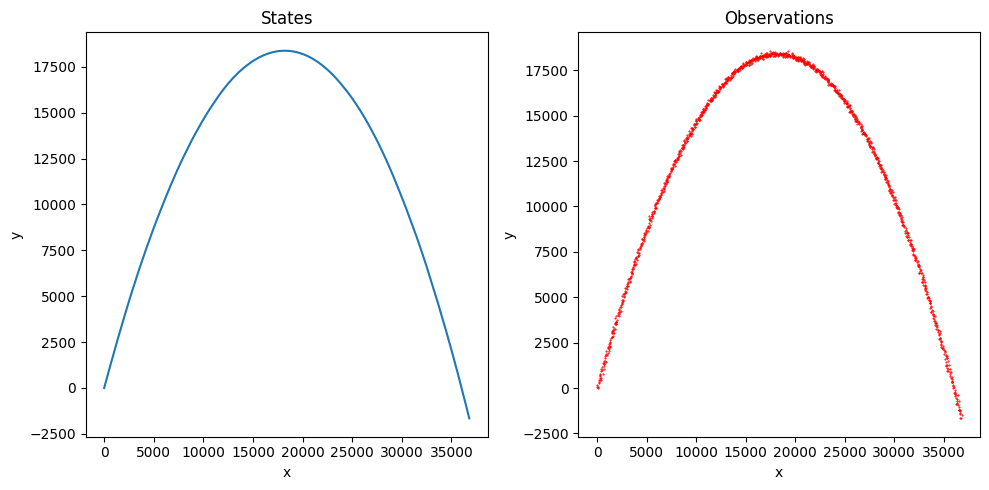

In [282]:
states, observations = kf.evolve(np.array([0, 0, 300, 600]), 1250)

# plot the states and observations side by side
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(states[0,:], states[1,:])
plt.xlabel('x')
plt.ylabel('y')
plt.title('States')

plt.subplot(122)
plt.plot(observations[0,:], observations[1,:], 'r.', markersize=1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Observations')
plt.tight_layout()

plt.show()


## Problem 5

Calculate an initial state estimate $\hat{\mathbf{x}}_{200}$ as follows: For the horizontal and vertical positions, simply use the observed position at time 200. 
For the velocity, compute the average velocity between the observations $\mathbf{z}_k$ and $\mathbf{z}_{k+1}$ for $k = 200,\dots, 208$, then average these 9 values and take this as the initial velocity estimate.
Using the initial state estimate, $P_{200} = 10^6\cdot Q$, and your Kalman Filter, compute the next 600 state estimates, i.e. compute $\hat{\mathbf{x}}_{201},\dots,\hat{\mathbf{x}}_{800}$. 
Plot these state estimates as a smooth green curve together with the radar observations (as red dots) and the entire true state sequence (as
a blue curve). 
Zoom in to see how well it follows the true path. 

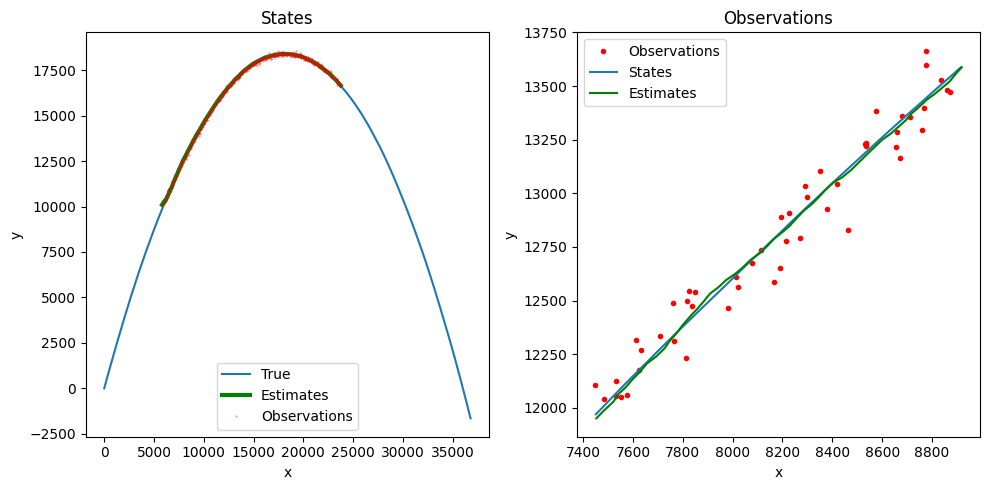

In [283]:
# observations
z = observations[:,200:800]


velocities = np.diff(observations[:,200:209], axis=1)

# get the average velocity
v = np.mean(velocities, axis=1)

x0 = np.array([z[0,0], z[1,0], v[0], v[1]])

# initial state estimate
P = 10**6 * Q

# estimate the states
estimates, norms = kf.estimate(x0, P, z, return_norms=True)

# plot the states and observations side by side
plt.figure(figsize=(10, 5))
plt.subplot(121)

# plot the true states
plt.plot(states[0,:], states[1,:])

# plot the estimated states
plt.plot(estimates[0,:], estimates[1,:], 'g', linewidth=3)

# plot the observations
plt.plot(z[0,:], z[1,:], 'r.', markersize=.5)

plt.xlabel('x')
plt.ylabel('y')
plt.title('States')
plt.legend(['True', 'Estimates', 'Observations'])

plt.subplot(122)
start, end = 250, 300
plt.plot(observations[0,start:end], observations[1,start:end], 'r.', label='Observations')
plt.plot(states[0,start:end], states[1,start:end], label='States')
plt.plot(estimates[0,start - 200:end - 200], estimates[1,start - 200:end - 200], 'g', label='Estimates')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Observations')
plt.legend()
plt.tight_layout()

plt.show()


## Problem 7

Using the final state estimate $\hat{\mathbf{x}}_{800}$ that you obtained in Problem 5, predict the future states of the projectile until it hits the ground. 
Predicting approximately the next 450 states should be sufficient.
Plot the actual state sequence together with the predicted state sequence (as a yellow curve), and observe how near the prediction is to the actual point of impact.

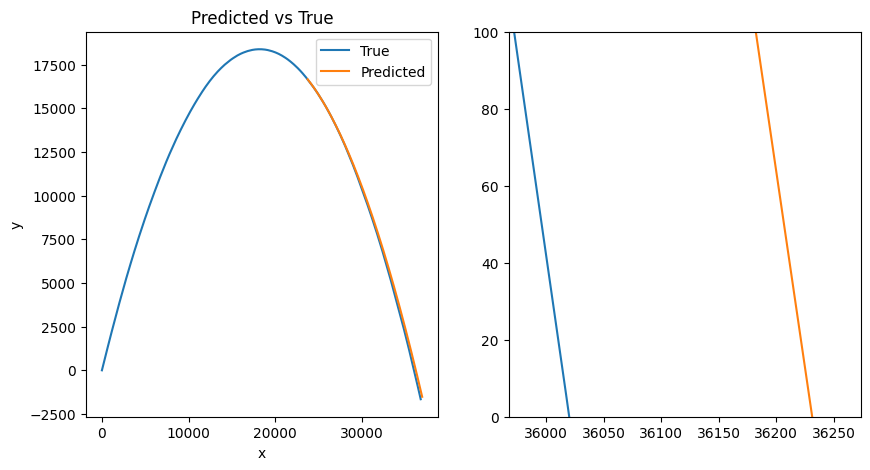

In [284]:
x0 = np.array([0, 0, 300, 600])
predicted = kf.predict(estimates[:,-1],450)

# plot the estimated states
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(states[0], states[1], label='True')
plt.plot(predicted[0], predicted[1], label='Predicted')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Predicted vs True')
plt.legend()

# create a dynamic xlim to always plot both sequences together
plt.subplot(122)
x1 = states[0,:][np.where(states[1,:]>=0)][-1]
x2 = predicted[0,:][np.where(predicted[1,:]>=0)][-1]
plt.xlim(min(x1,x2)-50, max(x1,x2)+50)
plt.ylim(0, 100)
plt.plot(states[0,:], states[1,:], label='True')
plt.plot(predicted[0,:], predicted[1,:], label='Predicted')

## Problem 9

Using your state estimate $\hat{\mathbf{x}}_{250}$, predict the point of origin of the projectile along with all states leading up to time step 250. 
Note that you may have to take a few extra time steps to predict the point of origin. 
Plot these predicted states (in green) together with the original state sequence. 
Zoom in to see how accurate your prediction is. 
Repeat the prediction starting with $\hat{\mathbf{x}}_{600}$. 
Compare to the previous results. 
Which is better? 
Why?

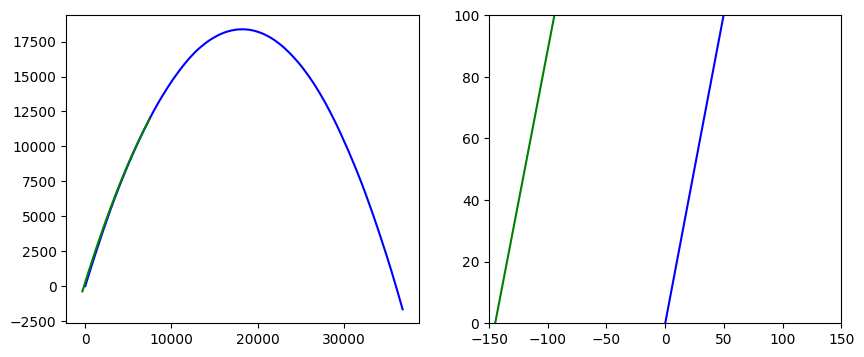

In [285]:
# plot the first 250 predictions
extra = 10
k = 250 + extra
x0 = estimates[:, k - extra - 200]
# rewind the states
rewound = kf.rewind(x0, k)

# plot the rewound states until time 250, then the true states
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(states[0],states[1], color = 'blue')
plt.plot(rewound[0],rewound[1], color = 'green')

plt.subplot(1,2,2)
plt.plot(states[0],states[1], color = 'blue')
plt.plot(rewound[0],rewound[1], color = 'green')
plt.xlim(-150,150)
plt.ylim(0,100)

plt.show()

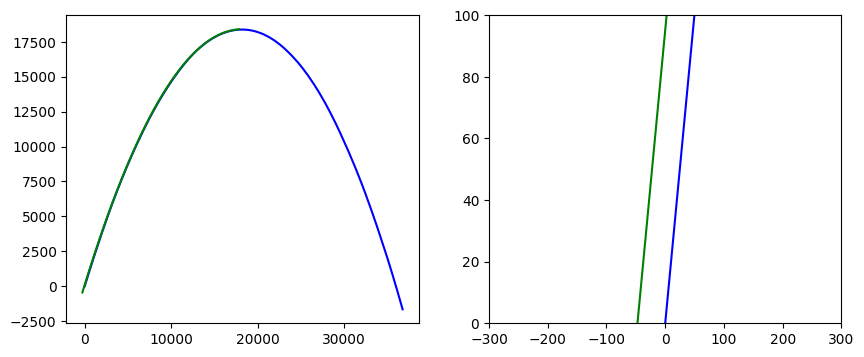

In [286]:
# plot the estimated states
extra = 10
k = 600 + extra
x0 = estimates[:, k - extra - 200]

# rewind the states
rewound = kf.rewind(x0, k)

# plot the rewound states until time 600, then the true states
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(states[0],states[1], color = 'blue')
plt.plot(rewound[0],rewound[1], color = 'green')

plt.subplot(1,2,2)
plt.plot(states[0],states[1], color = 'blue')
plt.plot(rewound[0],rewound[1], color = 'green')
plt.xlim(-300,300)
plt.ylim(0,100)

plt.show()

The prediction starting at 600 is better because the filter is able to adapt the state estimates with more observations to a more accurate estimate, thus the starting estimate is better